# CNN using Pytorch for Cancer detection

In [4]:
# necessary packages
import os
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import cv2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Lungenkrebs Datensatz in das System Laden

In [11]:
lung_dataset = '../lung_colon_image_set/lung_image_sets'
if not os.path.exists(lung_dataset):
    raise FileNotFoundError(f"Dataset path {lung_dataset} does not exist!")

class_names=sorted(os.listdir(lung_dataset))
print(f"Classes found: {class_names}")

Classes found: ['lung_aca', 'lung_n', 'lung_scc']


## Bilder in Train, Test und Validierungssplits aufteilen

Teilt die Bilder in drei Kategorien ein
- 80% sind Trainingsdaten
- 10% sind Testdaten
- 10% sind Validierungsdaten

In [12]:
def prepare_splits(datadir, split_ratios=(0.8, 0.1, 0.1)):
    all_data = {cls: [os.path.join(datadir, cls, fname)
                      for fname in os.listdir(os.path.join(datadir, cls))]
                for cls in class_names}
    
    splits = {'train': [], 'valid': [], 'test': []}
    
    for cls, files in all_data.items():
        train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]))
        val_files, test_files = train_test_split(temp_files, test_size=split_ratios[2] / (split_ratios[1] + split_ratios[2]))
        
        splits['train'].extend(train_files)
        splits['valid'].extend(val_files)
        splits['test'].extend(test_files)
        
    return splits

data_splits = prepare_splits(lung_dataset)
print(f"Training samples: {len(data_splits['train'])}")
print(f"Validation samples: {len(data_splits['valid'])}")
print(f"Test samples: {len(data_splits['test'])}")

Training samples: 12000
Validation samples: 1500
Test samples: 1500


In [13]:
class LungDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.labels = [class_names.index(os.path.basename(os.path.dirname(fp))) for fp in file_paths]
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])    

# Datasets
train_dataset = LungDataset(data_splits['train'], transform=transform)
val_dataset = LungDataset(data_splits['valid'], transform=transform)
test_dataset = LungDataset(data_splits['test'], transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##### CNN Klasse mit 6 convolutional Layer, 1 Pooling Layer, 3 batch normalizer und 2 Fully connected layers

In [15]:
class CNN_Model(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.bn1(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.bn2(x)
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.bn3(x)
        
        #print(x.size())
        #print(f"Shape after conv layers: {x.shape}")
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        

In [ ]:
# grad cam with bounding box


## Training des Modells

Training des Modells auf einem Trainingsdatensatz und Validierung durch einen Validierungsdatensatz über eine bestimmte Anzahl von Epochen. Verwendung von Adam-Optimierer und die Kreuzentropie-Verlustfunktion. Die Funktion verfolgt und speichert die Trainingsverluste, Validierungsverluste und Validierungsgenauigkeit für jede Epoche.

#### Ablauf
- Initialisiert den Adam-Optimierer und die Kreuzentropie-Verlustfunktion
- Verschiebt Modell auf das angegebene Gerät (CPU oder GPU)
- Initialisiert Listen zur Speicherung der Verluste und Genauigkeit
- **Trainingsschritte pro Epoche**

    - Daten auf das Gerät verschieben
    - Gradienten zurücksetzen
    - Vorwärtsdurchlauf, Parameter aktualieren
    - Verlust akkumulieren
    - Durchschnittliche Trainingsverluste berechnen

- **Validierung pro Epoche**

    - Modell in Evaluierungsmodus setzen, verlust und Zähler initialisieren
    - Für jede Charge:
        - Daten auf Gerät schieben
        - Vorwärtsdurchlauf, Verlust berechnen
        - Verlust akkumulieren
        - Vorhersagen analysieren, Genauigkeit berechnen
    - Durchschnittlichen Validierungsverlust und -genauigkeit berechnen und ausgeben
    
- Gibt die Listen der Trainingsverluste, Validierungsverluste und Validierungsgenauigkeiten zurück


In [16]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
    
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")
    

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        epoch_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append (epoch_val_loss)
        val_accuracies.append(val_accuracy)
                
        val_accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy}")
    
    return train_losses, val_losses, val_accuracies

In [74]:
if __name__ == "__main__":
    model = CNN_Model(num_classes=len(class_names))
    train_model(model, train_loader, val_loader)

    # Testen oder Beispielbild mit Bounding Boxes
    print("Training abgeschlossen.")

Epoch 10, Loss: 0.03728240782010228
Validation Loss: 0.020929389866185366, Validation Accuracy: 99.33333333333333
Training abgeschlossen.


In [ ]:
model = torch.load('./lung_cancer_model_2.pth', weights_only=False)
def visualize_predictions(model, test_loader, class_names):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    fig = plt.figure(figsize=(15, 10))
    for idx in range(20): 
        ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
        img = images[idx].permute(1, 2, 0)  
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  
        img = img.numpy().clip(0, 1)
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predicted[idx]]}")

    plt.show()


visualize_predictions(model, test_loader, class_names)

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [77]:
def test_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    test_accuracy = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return all_labels, all_preds

all_labels, all_preds = test_model(model, test_loader)

Test Accuracy: 99.47%


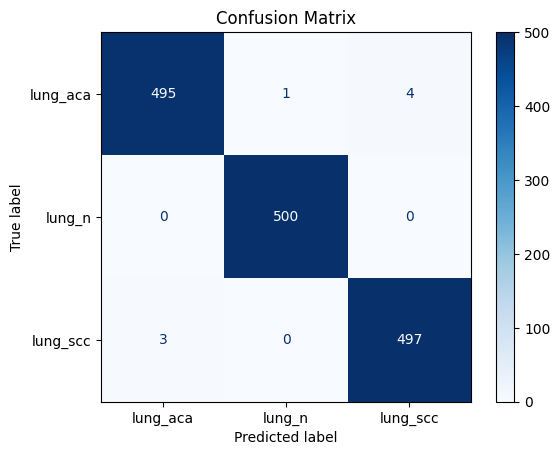

In [78]:
cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, num_epochs=10)
# plotting the loss and accuracy
def plot_loss_accuracy(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.title("Accuracy")
    plt.legend()

    plt.show()
    
plot_loss_accuracy(train_losses, val_losses, val_accuracies)

KeyboardInterrupt: 

### Saving the model to a file

In [80]:
# savving the model
save_path = 'lung_cancer_model_2.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to lung_cancer_model_2.pth
